In [1]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import threading
import cv2
import numpy as np

In [2]:
model_path = '/Users/ayushjain/Downloads/PoseLandmarkerLite.task'

In [3]:
import math

In [4]:
def compute_angle(A, B, C):
    # Vector BA
    BA = [A.x - B.x, A.y - B.y, A.z - B.z]
    # Vector BC
    BC = [C.x - B.x, C.y - B.y, C.z - B.z]

    # Dot product
    dot_product = sum(a*b for a, b in zip(BA, BC))

    # Magnitude of vectors
    mag_BA = math.sqrt(sum(a*a for a in BA))
    mag_BC = math.sqrt(sum(b*b for b in BC))

    # Cosine of the angle
    cos_theta = dot_product / (mag_BA * mag_BC)

    # Angle in radians
    theta = math.acos(cos_theta)

    # Convert to degrees
    theta_deg = math.degrees(theta)

    return theta_deg

In [5]:
BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.VIDEO)

In [6]:
cap = cv2.VideoCapture('/Users/ayushjain/Downloads/barbell biceps curl_10.mp4')

In [7]:
fps = max(30, cap.get(cv2.CAP_PROP_FPS))

In [8]:
landmarker = PoseLandmarker.create_from_options(options)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output, display

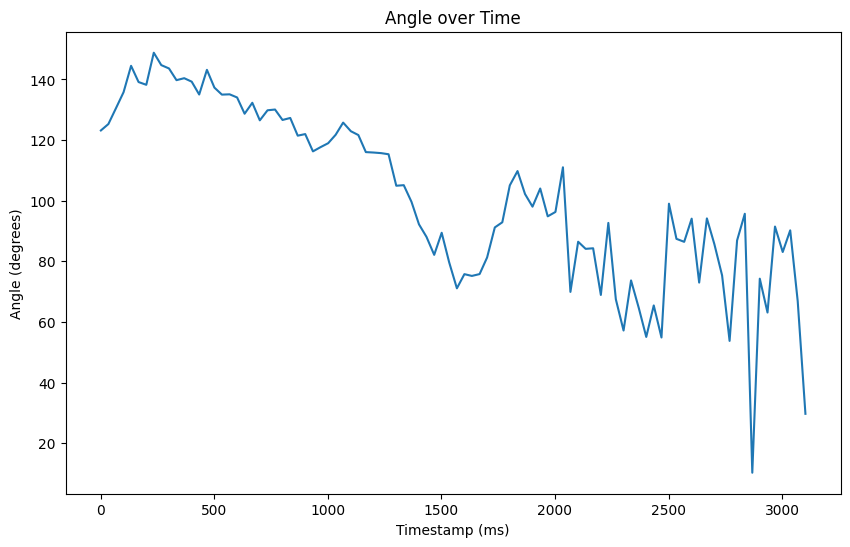

In [10]:
fig, ax = plt.subplots()
ax.set_title("Angles Over Time")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Angle (degrees)")

angles = []
timestamps = []


def update_plot(*args):
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, angles)
    plt.xlabel('Timestamp (ms)')
    plt.ylabel('Angle (degrees)')
    plt.title('Angle over Time')
    plt.show()

line, = ax.plot(timestamps, angles, '-')
plt.show(); 

def process_video():
    while True: 
        ret, frame = cap.read()

        if not ret: 
            break

        timestamp_ms = int(cap.get(cv2.CAP_PROP_POS_MSEC))

        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)        
        pose_landmarker_result = landmarker.detect_for_video(mp_image, timestamp_ms)

        if pose_landmarker_result.pose_landmarks is None or len(pose_landmarker_result.pose_landmarks) < 1:
            continue  # skip this frame

        point_A = pose_landmarker_result.pose_landmarks[0][16]
        point_B = pose_landmarker_result.pose_landmarks[0][14]
        point_C = pose_landmarker_result.pose_landmarks[0][12]

        angle = compute_angle(point_A, point_B, point_C)

        # Add the angles and timestamps for matplotlib
        angles.append(angle)
        timestamps.append(timestamp_ms)

        update_plot()

        cv2.imshow('Video', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

process_video()
